<a href="https://colab.research.google.com/github/issa-project/issa-pipeline/blob/main/notebooks/issa_descriptor_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of Thematic Descriptors in ISSA dataset

**Comparing human and automated indexation of the document text**  

Use case: Agritrop ISSA

Endpoint: https://data-issa.cirad.fr/sparql

In [11]:
import os
try:
    isColab = os.environ['GCE_METADATA_TIMEOUT']
    if isColab:
        !pip install SPARQLWrapper
except:
    pass

In [12]:
import pandas as pd
import numpy as np
import json

from SPARQLWrapper import SPARQLWrapper, JSON

import matplotlib.pyplot as plt

from IPython.display import display

In [13]:
def sparql_service_to_dataframe(service, query):
    """
    Helper function to convert SPARQL results into a Pandas DataFrame.
    
    Credit to Ted Lawless https://lawlesst.github.io/notebook/sparql-dataframe.html
    """
    sparql = SPARQLWrapper(service)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    result = sparql.query()

    processed_results = json.load(result.response)
    cols = processed_results['head']['vars']

    out = []
    for row in processed_results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)

    return pd.DataFrame(out, columns=cols)

In [14]:
issa_agritrop_endpoint = 'https://data-issa.cirad.fr/sparql'

## Per document statisticts

### Calculate thematic desciptors indexing quality statistics: 

- Recall
- Precision
- F1 score
- Jaccard index

In [15]:
quality_metrics_query_template = '''
PREFIX dce: <http://purl.org/dc/elements/1.1/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX prov: <http://www.w3.org/ns/prov#>
prefix bibo:   <http://purl.org/ontology/bibo/>
PREFIX dct:    <http://purl.org/dc/terms/>
PREFIX fabio:  <http://purl.org/spar/fabio/>
PREFIX oa:     <http://www.w3.org/ns/oa#>
PREFIX rdfs:   <http://www.w3.org/2000/01/rdf-schema#>
PREFIX issa:   <http://data-issa.cirad.fr/>
PREFIX issapr:   <http://data-issa.cirad.fr/property/>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX skosxl: <http://www.w3.org/2008/05/skos-xl#>

SELECT  ?paper ?paperID
        ?TP ?FN ?FP 
        (?TP / (xsd:float( ?TP + ?FN) + 0.000001)  as ?Recall)
        (?TP / (xsd:float( ?TP + ?FP) + 0.000001)  as ?Precision)
        ( 2 * ?Precision * ?Recall / (?Precision + ?Recall + 0.000001) as ?F1)
        ( ?TP / xsd:float(?UNION) as ?JaccardIndex)

FROM <http://data-issa.cirad.fr/graph/articles>
FROM <http://data-issa.cirad.fr/graph/thematic-descriptors>
FROM <http://data-issa.cirad.fr/graph/annif-descriptors>
FROM <http://agrovoc.fao.org/graph>

WHERE {
  SELECT  ?paper ?paperID
          (sum(?tp) as ?TP)
          (sum(?fn) as ?FN)
          (sum(?fp) as ?FP)
          (count (distinct ?descrUri) as ?UNION)

  WHERE { 
    # need this encapsulating select to eliminate the same parents 
    SELECT distinct ?paper ?paperID ?descrUri ?tp ?fp ?fn
    WHERE {
      #VALUES (?paper) { (<http://data-issa.cirad.fr/article/263679>) }

      ?paper a bibo:AcademicArticle, fabio:ResearchPaper;
             dct:identifier ?paperID;
             dce:language ?lang.
             FILTER (?lang = "%s")

      {
        ?descrHuman a issa:ThematicDescriptorAnnotation;
                    oa:hasBody ?descrUri;
                    oa:hasTarget ?paper;
                    issapr:rank  ?rankHuman;
                    prov:wasAttributedTo issa:AgritropDocumentalist.  

        optional {
          ?descrAnnif a issa:ThematicDescriptorAnnotation;
                      oa:hasBody/skos:broader{%d,%d} ?descrUri;
                      oa:hasTarget ?paper;
                      issapr:rank  ?rankAnnif;
                      prov:wasAttributedTo issa:AnnifSubjectIndexer.
                      FILTER (?rankAnnif < %d)  }
      }
      UNION
      {
        ?descrAnnif a issa:ThematicDescriptorAnnotation;
                    oa:hasBody?descrUri;
                    oa:hasTarget ?paper;
                    issapr:rank  ?rankAnnif;
                    prov:wasAttributedTo issa:AnnifSubjectIndexer.
                    FILTER (?rankAnnif < %d )

        optional {
          ?descrHuman a issa:ThematicDescriptorAnnotation;
                      oa:hasBody/skos:broader{%d,%d} ?descrUri;
                      oa:hasTarget ?paper;
                      issapr:rank  ?rankHuman;
                      prov:wasAttributedTo issa:AgritropDocumentalist  }
      }

    bind (IF( BOUND(?descrHuman) &&  BOUND(?descrAnnif), 1, 0 ) as ?tp)
    bind (IF( BOUND(?descrHuman) &&  !BOUND(?descrAnnif), 1, 0 ) as ?fn)
    bind (IF( !BOUND(?descrHuman) &&  BOUND(?descrAnnif), 1, 0 ) as ?fp)

    #OPTIONAL {# Find labels
    #      ?descrUri skosxl:prefLabel/skosxl:literalForm ?descrLabel.
    #      FILTER langMatches(lang(?descrLabel), "en") }
  
 }
}
group by ?paper ?paperID
having ((sum(?tp) + sum(?fn)) > 0   ) # select only the papers that have human descriptors
}
#limit 10
'''

In [72]:
def query_metrics(language, broader=(0,0), topK=100 ):
    langs = { 'en': 'eng', 
              'fr' :'fre'}
    (broader_from, broader_to)=  broader 

    print(language, end=' ')     

    df= sparql_service_to_dataframe(issa_agritrop_endpoint, 
                                        quality_metrics_query_template % (langs[language] ,
                                        broader_from, broader_to, topK,
                                        topK, broader_from, broader_to) )
    df= df.astype({'paperID': 'int',
                    'TP': 'float',
                    'FN': 'float',
                    'FP': 'float',
                    'Recall': 'float',
                    'Precision': 'float',
                    'F1': 'float',
                    'JaccardIndex': 'float' })
    print(df.shape)

    return df

topK = 100
df_metrics = {}

for lang in ['en', 'fr']:
    df_metrics[lang] = query_metrics(lang)
    

df_metrics['both'] = pd.concat(df_metrics.values() )

en (4603, 9)
fr (8270, 9)
both (12873, 9)


In [73]:
def summary_dataframe(df_metrics, col_prefix='', col_suffix='', from_id=0):
    df_summary = pd.DataFrame(columns=['language', 'Recall', 'Precision', 'F1 score', 'Jaccard Index'])

    df_summary['language'] = pd.Series(['en', 'fr', 'both'])
    df_summary.set_index('language', inplace=True)
    
    sr_count = pd.Series(data=[0,0,0], index=['en', 'fr', 'both'], dtype='int')
    
    df_metrics_view = df_metrics.copy()
    #df_metrics_view['both'] = pd.concat(df_metrics_view.values() )

    for lang, df in df_metrics_view.items():
        df = df.loc[df.paperID > from_id,]
        sr_count[lang] = df.shape[0]
        df_summary.loc[lang , 'F1 score'] = df.F1.mean()
        df_summary.loc[lang , 'Recall'] = df.Recall.mean()
        df_summary.loc[lang , 'Precision'] = df.Precision.mean()
        df_summary.loc[lang , 'Jaccard Index'] = df.JaccardIndex.mean()


    df_summary.rename(columns= dict(zip(df_summary.columns, [ col_prefix  + 'avg. '+  c + col_suffix for c in df_summary.columns])),
                            inplace=True)
    
    df_summary.insert(0, 'Docs', sr_count)
                                
    return df_summary 


def show_hist(plt, i, df , column='F1', 
              hist_color='lightblue', mean_color='indigo', median_color='blue'):
    mean   = df.loc[:, column].mean()
    median = df.loc[:, column].median()

    plt.subplot(1 , 3, i+1)

    plt.hist(df.loc[:, column], 20, facecolor=hist_color)
    plt.xlabel (['English', 'French', 'Both'][i])
    plt.ylim(0, 1000)
    plt.axvline(mean, color='indigo')
    plt.text(mean + 0.01, 50, 'mean=%.2f' % mean, color=mean_color)

    plt.axvline(median, color="blue")
    plt.text(median + 0.01, 100, 'median=%.2f' % median , color=median_color)

In [74]:
df_summary = summary_dataframe(df_metrics)

pd.options.display.float_format = '{:,.2f}'.format
df_summary.head()    

,Docs,avg. Recall,avg. Precision,avg. F1 score,avg. Jaccard Index
language,,,,,
en,4603,0.78,0.52,0.60,0.46
fr,8270,0.73,0.50,0.56,0.43
both,12873,0.75,0.51,0.57,0.44


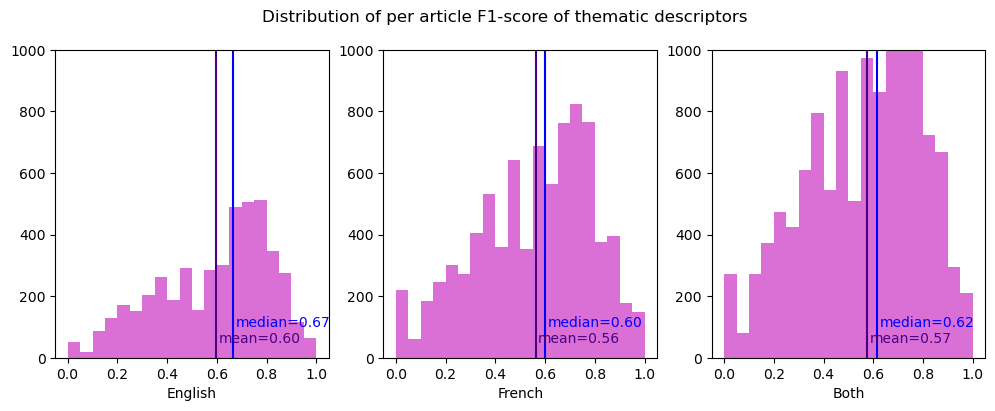

In [76]:
fig = plt.figure(figsize=(12, 4))
fig.suptitle('Distribution of per article F1-score of thematic descriptors')

for i, df_f1 in enumerate(df_metrics.values()):
    show_hist(plt, i, df_f1, 'F1', hist_color='orchid')
#show_hist(plt, i+1, pd.concat(df_metrics.values() ), 'F1', hist_color='orchid')
    
plt.show()

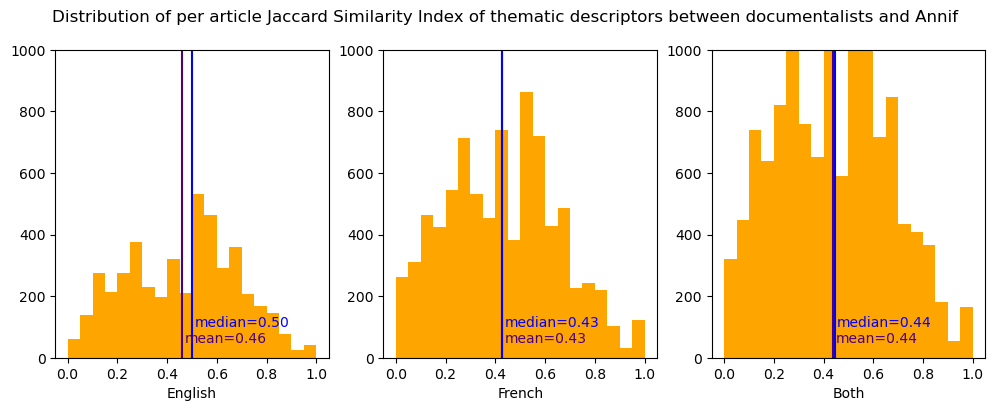

In [77]:
fig = plt.figure(figsize=(12, 4))
fig.suptitle('Distribution of per article Jaccard Similarity Index of thematic descriptors between documentalists and Annif')

for i, df_js in enumerate(df_metrics.values()):
    show_hist(plt, i, df_js , column='JaccardIndex', hist_color='orange')

plt.show()

#### Calculate statistics @10

In [78]:
topK = 11
df_metrics_at10 = {}

for lang in ['en', 'fr']:
    df_metrics_at10[lang] = query_metrics(lang, broader=(0,0), topK=topK)

df_metrics_at10['both'] = pd.concat(df_metrics_at10.values() )
    
df_summary_at10 = summary_dataframe(df_metrics_at10, col_suffix='@10')

pd.options.display.float_format = '{:,.2f}'.format
df_summary_at10.head()    

en (4603, 9)
fr (8270, 9)
both (12873, 9)


,Docs,avg. Recall@10,avg. Precision@10,avg. F1 score@10,avg. Jaccard Index@10
language,,,,,
en,4603,0.68,0.58,0.59,0.45
fr,8270,0.65,0.54,0.56,0.42
both,12873,0.66,0.55,0.57,0.43


#### Calculate statistics @5

In [79]:
topK = 6
df_metrics_at5 = {}

for lang in ['en', 'fr']:
    df_metrics_at5[lang] = query_metrics(lang, broader=(0,0), topK=topK)

df_metrics_at5['both'] = pd.concat(df_metrics_at5.values() )

df_summary_at5 = summary_dataframe(df_metrics_at5, col_suffix='@5')

pd.options.display.float_format = '{:,.2f}'.format
df_summary_at5.head()   

en (4603, 9)
fr (8270, 9)
both (12873, 9)


,Docs,avg. Recall@5,avg. Precision@5,avg. F1 score@5,avg. Jaccard Index@5
language,,,,,
en,4603,0.47,0.70,0.52,0.38
fr,8270,0.47,0.65,0.51,0.37
both,12873,0.47,0.67,0.51,0.37


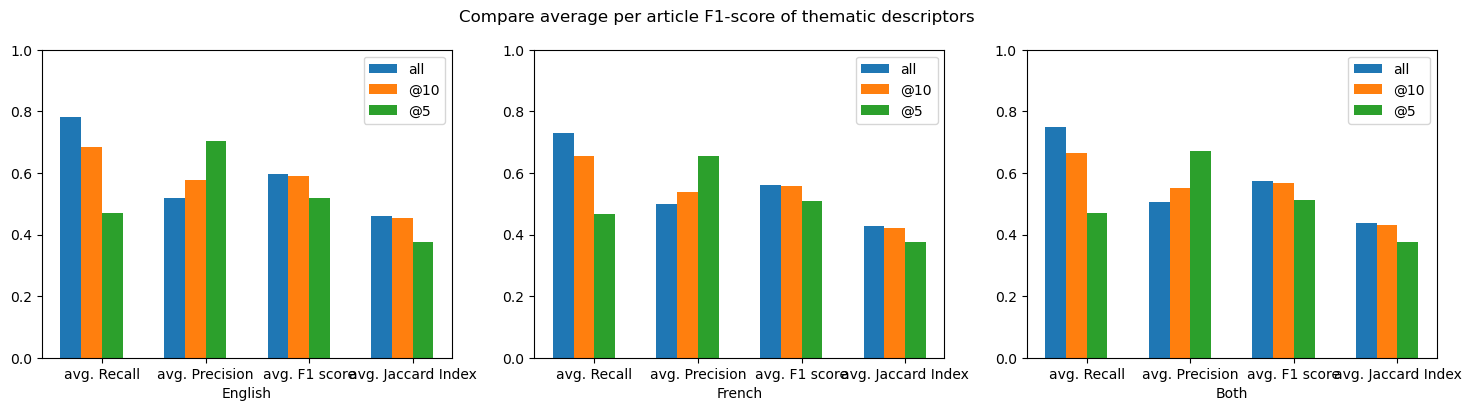

In [85]:
fig = plt.figure(figsize=(18, 4))
fig.suptitle('Compare average per article F1-score of thematic descriptors')

def _compare_metrics_plot(i , row_num):
    metrics_labels = ['avg. Recall', 'avg. Precision', 'avg. F1 score', 'avg. Jaccard Index']

    x = np.arange(len(metrics_labels))  # the label locations
    width = 0.20  # the width of the bars

    plt.subplot(1 , 3, i+1)
    
    plt.bar(x - width/2*3, df_summary.iloc[row_num,1:],      width=width, label='all')
    plt.bar(x - width/2,   df_summary_at10.iloc[row_num,1:], width=width, label='@10')
    plt.bar(x + width/2,   df_summary_at5.iloc[row_num,1:],  width=width, label='@5')
    plt.xticks(x, metrics_labels)
    plt.xlabel (['English', 'French', 'Both'][i])
    plt.ylim(0, 1)
    plt.legend(loc='upper right')

_compare_metrics_plot(0, 0)
_compare_metrics_plot(1, 1)
_compare_metrics_plot(2, 2)

plt.show()

In [86]:
table_style = [{"selector": "", "props": [("border", "3px solid lightblue !important")]},
               {"selector": "td", "props": [("border", "1px solid grey !important")]},
               {"selector": "th", "props": [("border", "1px solid grey !important")]}  ]
               
pd.concat([df_summary.transpose(), df_summary_at10.transpose(), df_summary_at10.transpose()], axis=0) \
     .sort_index() \
     .set_index(pd.MultiIndex.from_product([df_summary.columns.sort_values(), ['', '@10', '@5']])) \
          .round(2) \
     .transpose() \
     .style.set_table_styles(table_style) \
     .format(precision=2) \
     .set_caption('Compare metrics for different number of automatically predicted descriptors') \
     .highlight_max(subset='avg. F1 score', color='lightblue', axis=1) \
     .highlight_max(subset='avg. Jaccard Index', color='lightblue', axis=1) \
     .highlight_max(subset='avg. Precision', color='lightblue', axis=1) \
     .highlight_max(subset='avg. Recall', color='lightblue', axis=1)

CONCLUSION: Taking top K of the Annif descriptors improves the precision but reduces the recall more significantly. 

#### Calculate statistic including immediate parents

In [84]:
topK = 100
broader= (0,1)

df_metrics_with_parents = {}

for lang in ['en', 'fr']:
    df_metrics_with_parents[lang] = query_metrics(lang, broader=broader, topK=topK)
    
df_metrics_with_parents['both'] = pd.concat(df_metrics_with_parents.values() )

df_summary_with_parents = summary_dataframe(df_metrics_with_parents, col_suffix=' (+parent)')

#pd.options.display.float_format = '{:,.2f}'.format
#df_summary_with_parents.head()   

en (4603, 9)
fr (8270, 9)


#### Calculate statistic including ancestors  

In [83]:
topK = 100
broader= (0,20)

df_metrics_with_ancestors = {}

for lang in ['en', 'fr']:
    df_metrics_with_ancestors[lang] = query_metrics(lang, broader=broader, topK=topK)

df_metrics_with_ancestors['both'] = pd.concat(df_metrics_with_ancestors.values() )

df_summary_with_ancestors = summary_dataframe(df_metrics_with_ancestors, col_suffix=' (+parents)')

#pd.options.display.float_format = '{:,.2f}'.format
#df_summary_with_ancestors.head()   

en (4603, 9)
fr (8270, 9)
both (12873, 9)


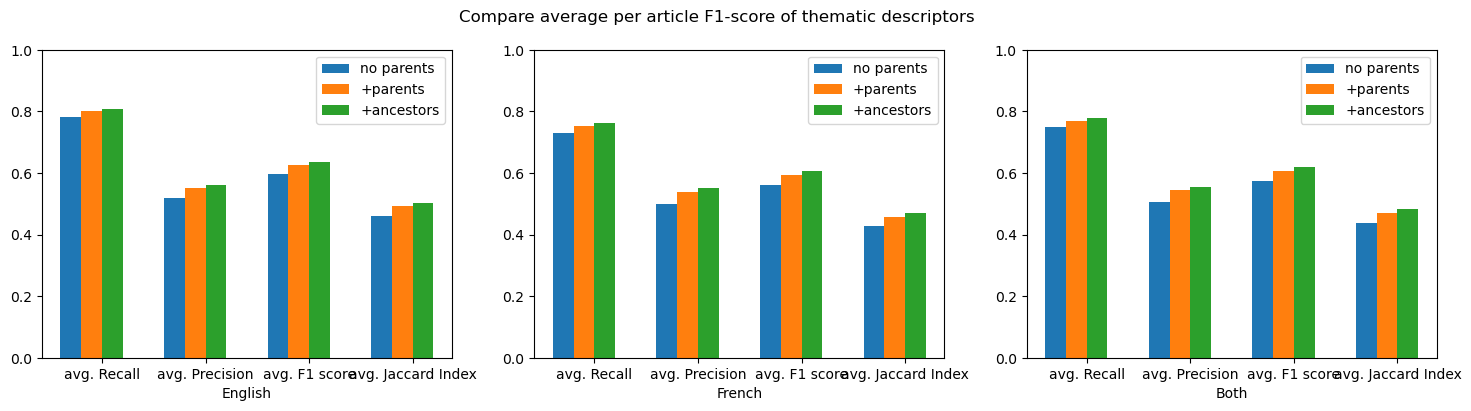

In [87]:
fig = plt.figure(figsize=(18, 4))
fig.suptitle('Compare average per article F1-score of thematic descriptors')

def _compare_metrics_parents(i , row_num):
    metrics_labels = ['avg. Recall', 'avg. Precision', 'avg. F1 score', 'avg. Jaccard Index']

    x = np.arange(len(metrics_labels))  # the label locations
    width = 0.20  # the width of the bars

    plt.subplot(1 , 3, i+1)
    
    plt.bar(x - width/2*3, df_summary.iloc[row_num,1:], width=width, label='no parents')
    plt.bar(x - width/2,   df_summary_with_parents.iloc[row_num,1:], width=width, label='+parents')
    plt.bar(x + width/2,   df_summary_with_ancestors.iloc[row_num,1:], width=width, label='+ancestors')
    plt.xticks(x, metrics_labels)
    plt.xlabel (['English', 'French', 'Both'][i])
    plt.ylim(0, 1)
    plt.legend(loc='upper right')

_compare_metrics_parents(0, 0)
_compare_metrics_parents(1, 1)
_compare_metrics_parents(2, 2)

plt.show()

In [88]:
#    [{'selector': 'thead',
#      'props': [('background-color', 'lightblue') ]}]
table_style = [{"selector": "", "props": [("border", "3px solid lightblue !important")]},
               {"selector": "td", "props": [("border", "1px solid grey !important")]},
               {"selector": "th", "props": [("border", "1px solid grey !important")]}  ]

pd.concat([df_summary.transpose(), df_summary_with_parents.transpose(), df_summary_with_ancestors.transpose()], axis=0) \
     .sort_index() \
     .set_index(pd.MultiIndex.from_product([df_summary.columns.sort_values(), ['', '(+parents)', '(+ancestors)']])) \
          .round(2) \
     .transpose() \
     .style.set_table_styles(table_style) \
     .format(precision=2) \
     .set_caption('Compare metrics for different levels of thesaurus hierarchies') \
     .highlight_max(subset='avg. F1 score', color='lightblue', axis=1) \
     .highlight_max(subset='avg. Jaccard Index', color='lightblue', axis=1) \
     .highlight_max(subset='avg. Precision', color='lightblue', axis=1) \
     .highlight_max(subset='avg. Recall', color='lightblue', axis=1)


CONCLUSION: including the thesaurus ancestors along with the descriptors indeed increases the quality metrics.

### Recalculate statistic for unseen documents

In [89]:
latest_training_paper_id = 600364

In [90]:
#print('Full dataset metrics')
#display(df_summary)

print('Latest documents metrics')
df_summary_latest = summary_dataframe(df_metrics, from_id = latest_training_paper_id)
#display(df_summary_latest)

print('Latest documents metrics @10')
df_summary_at10_latest = summary_dataframe(df_metrics_at10, from_id = latest_training_paper_id)
#display(df_summary_at10_latest) 

print('Latest documents metrics @5')
df_summary_at5_latest = summary_dataframe(df_metrics_at5, from_id = latest_training_paper_id)
#display(df_summary_at5_latest) 

print('Latest documents metrics with parents')
df_summary_with_parents_latest = summary_dataframe(df_metrics_with_parents, from_id = latest_training_paper_id)
#display(df_summary_with_parents_latest) 

print('Latest documents metrics with ancestors')
df_summary_with_ancestors_latest = summary_dataframe(df_metrics_with_ancestors, from_id = latest_training_paper_id)
#display(df_summary_with_ancestors_latest) 

Latest documents metrics
Latest documents metrics @10
Latest documents metrics @5
Latest documents metrics with parents
Latest documents metrics with ancestors


In [91]:
table_style = [{"selector": "", "props": [("border", "3px solid orchid !important")]},
               {"selector": "td", "props": [("border", "1px solid grey !important")]},
               {"selector": "th", "props": [("border", "1px solid grey !important")]}  ]
               
pd.concat([df_summary.transpose(), df_summary_latest.transpose()], axis=0) \
     .sort_index() \
     .set_index(pd.MultiIndex.from_product([df_summary_latest.columns.sort_values(), ['full', 'latest']])) \
          .round(2) \
     .transpose() \
     .style.set_table_styles(table_style) \
     .format(precision=2) \
     .set_caption('Compare metrics for full set and the latest documents only') \
     .highlight_max(subset='avg. F1 score', color='orchid', axis=1) \
     .highlight_max(subset='avg. Jaccard Index', color='orchid', axis=1) \
     .highlight_max(subset='avg. Precision', color='orchid', axis=1) \
     .highlight_max(subset='avg. Recall', color='orchid', axis=1)

In [92]:
table_style = [{"selector": "", "props": [("border", "3px solid lightpink !important")]},
               {"selector": "td", "props": [("border", "1px solid grey !important")]},
               {"selector": "th", "props": [("border", "1px solid grey !important")]}  ]
               
pd.concat([df_summary_latest.transpose(), df_summary_at10_latest.transpose(), df_summary_at5_latest.transpose()], axis=0) \
     .sort_index() \
     .set_index(pd.MultiIndex.from_product([df_summary_latest.columns.sort_values(), ['', '@10', '@5']])) \
          .round(2) \
     .transpose() \
     .style.set_table_styles(table_style) \
     .format(precision=2) \
     .set_caption('Compare metrics for different number of automatically predicted descriptors for the latest documents') \
     .highlight_max(subset='avg. F1 score', color='lightpink', axis=1) \
     .highlight_max(subset='avg. Jaccard Index', color='lightpink', axis=1) \
     .highlight_max(subset='avg. Precision', color='lightpink', axis=1) \
     .highlight_max(subset='avg. Recall', color='lightpink', axis=1)

In [93]:
#    [{'selector': 'thead',
#      'props': [('background-color', 'lightblue') ]}]
table_style = [{"selector": "", "props": [("border", "3px solid lightpink !important")]},
               {"selector": "td", "props": [("border", "1px solid grey !important")]},
               {"selector": "th", "props": [("border", "1px solid grey !important")]}  ]

pd.concat([df_summary_latest.transpose(), df_summary_with_parents_latest.transpose(), df_summary_with_ancestors_latest.transpose()], axis=0) \
     .sort_index() \
     .set_index(pd.MultiIndex.from_product([df_summary_latest.columns.sort_values(), ['', '(+parents)', '(+ancestors)']])) \
          .round(2) \
     .transpose() \
     .style.set_table_styles(table_style) \
     .format(precision=2) \
     .set_caption('Compare metrics for different levels of thesaurus hierarchies') \
     .highlight_max(subset='avg. F1 score', color='lightpink', axis=1) \
     .highlight_max(subset='avg. Jaccard Index', color='lightpink', axis=1) \
     .highlight_max(subset='avg. Precision', color='lightpink', axis=1) \
     .highlight_max(subset='avg. Recall', color='lightpink', axis=1)

## Per descriptor statistics 

In [94]:
query_descriptors_count_templ = '''
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX oa:     <http://www.w3.org/ns/oa#>
PREFIX skos:   <http://www.w3.org/2008/05/skos-xl>
PREFIX skosxl: <http://www.w3.org/2008/05/skos-xl#>
PREFIX issa:   <http://data-issa.cirad.fr/>
PREFIX prov: <http://www.w3.org/ns/prov#>
PREFIX dct:    <http://purl.org/dc/terms/>
PREFIX schema: <http://schema.org/>
PREFIX gn:     <http://www.geonames.org/ontology#>

SELECT ?uri ?descriptorLabel ?indexer
      (count(distinct ?paper) as ?cnt)
      (max(?gn) as ?isGeo)
WHERE {
	?descriptor a issa:ThematicDescriptorAnnotation;
    oa:hasBody ?uri;
    oa:hasTarget ?paper;
    prov:wasAttributedTo ?indexer.
    FILTER (?indexer = %s) # issa:AgritropDocumentalist | issa:AnnifSubjectIndexer
  
  OPTIONAL {
        ?uri skosxl:prefLabel/skosxl:literalForm ?descriptorLabel.
        FILTER langMatches(lang(?descriptorLabel), "en" )
        
        BIND ( EXISTS {?gnUri gn:officialName|gn:alternateName|gn:name|gn:shortName ?descriptorLabel } as ?gn)
  }
}
group by  ?uri ?descriptorLabel ?indexer
order by desc(?cnt)
'''

In [95]:
indexers = {'human' : 'issa:AgritropDocumentalist',
            'annif': 'issa:AnnifSubjectIndexer'}
df_descr_count={}

for key, value in indexers.items():
    print(key, end=' ')
    df_descr_count[key] = sparql_service_to_dataframe(issa_agritrop_endpoint, query_descriptors_count_templ %  indexers[key])
    df_descr_count[key].dropna(inplace=True)
    df_descr_count[key] = df_descr_count[key].astype({'cnt': 'int', 'isGeo': 'int'})
    print(indexers[key] , df_descr_count[key].shape)



human issa:AgritropDocumentalist (8005, 5)
annif issa:AnnifSubjectIndexer (8069, 5)


In [64]:
cols = df_descr_count.keys()

df_descr_summary=pd.DataFrame(columns=cols)

for indexer in df_descr_count:
    df_descr_summary.loc['unique count', indexer] = df_descr_count[indexer].cnt.shape[0]
    df_descr_summary.loc['total count', indexer] =  df_descr_count[indexer].cnt.sum()
    df_descr_summary.loc['geo count', indexer] =  df_descr_count[indexer].isGeo.sum()


    df_descr_summary.loc['mean frequency', indexer] = df_descr_count[indexer].cnt.mean()
    df_descr_summary.loc['frequency std', indexer] =  df_descr_count[indexer].cnt.std()

    df_descr_summary.loc['% of low frequency', indexer] = df_descr_count[indexer][df_descr_count[indexer].cnt < 2].shape[0] / df_descr_count[indexer].shape[0]
    df_descr_summary.loc['% of high frequency', indexer] = df_descr_count[indexer][df_descr_count[indexer].cnt > 500 ].shape[0] / df_descr_count[indexer].shape[0]


table_style = [{"selector": "", "props": [("border", "3px solid lightblue !important")]},
               {"selector": "td", "props": [("border", "1px solid grey !important")]},
               {"selector": "th", "props": [("border", "1px solid grey !important")]}  ]
               
df_descr_summary.transpose() \
                .style.set_table_styles(table_style) \
                .format(precision=2) 


,unique count,total count,geo count,mean frequency,frequency std,% of low frequency,% of high frequency
human,8005,186070,311,23.24,81.19,0.28,0.00
annif,8069,163185,310,20.22,82.47,0.39,0.00


#### Human indexing

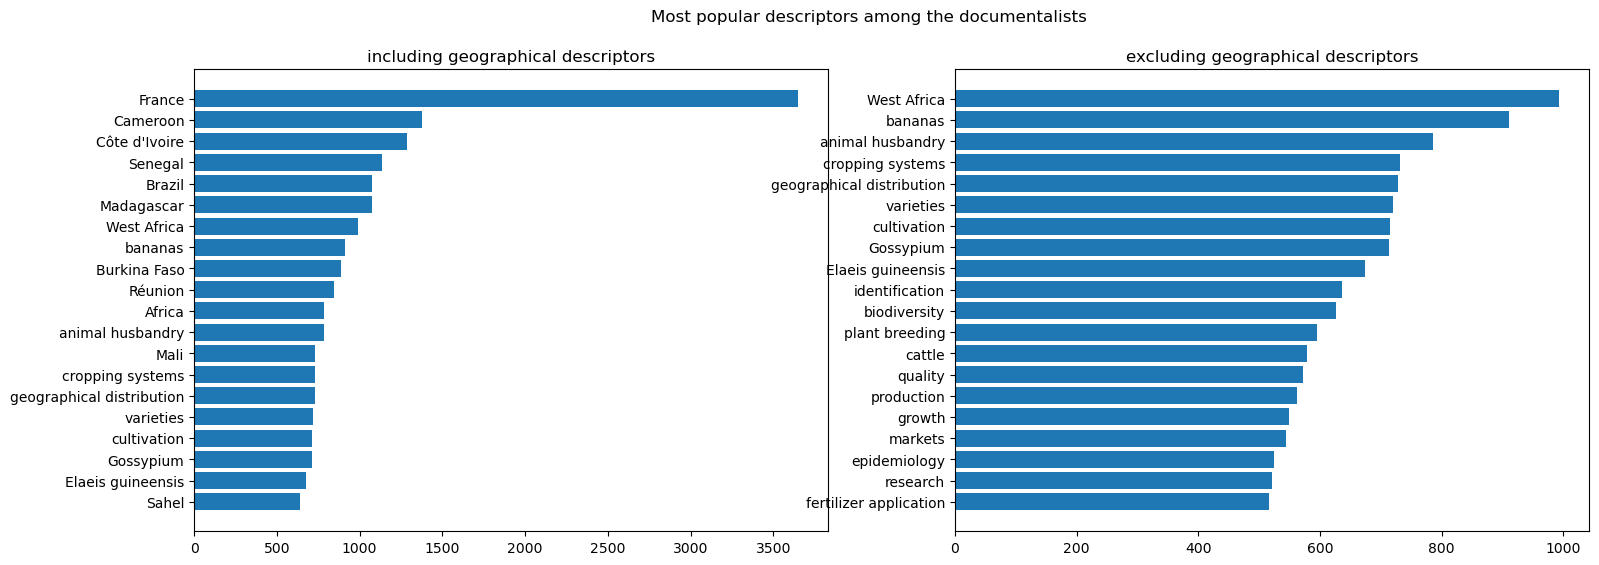

In [96]:
top_20 = df_descr_count['human'].sort_values(by='cnt', ascending=False)[:20]

top_20_non_geo = df_descr_count['human'][df_descr_count['human'].isGeo < 1].sort_values(by='cnt', ascending=False)[:20]

fig = plt.figure(figsize=(18, 6))
fig.suptitle('Most popular descriptors among the documentalists')

plt.subplot(1,2,1)
plt.barh(top_20.descriptorLabel, width=top_20.cnt ) 
plt.gca().invert_yaxis()
plt.title('including geographical descriptors')

plt.subplot(1,2,2)
plt.barh(top_20_non_geo.descriptorLabel, width=top_20_non_geo.cnt) 
plt.gca().invert_yaxis()
plt.title('excluding geographical descriptors')


plt.show()

#### Machine indexing

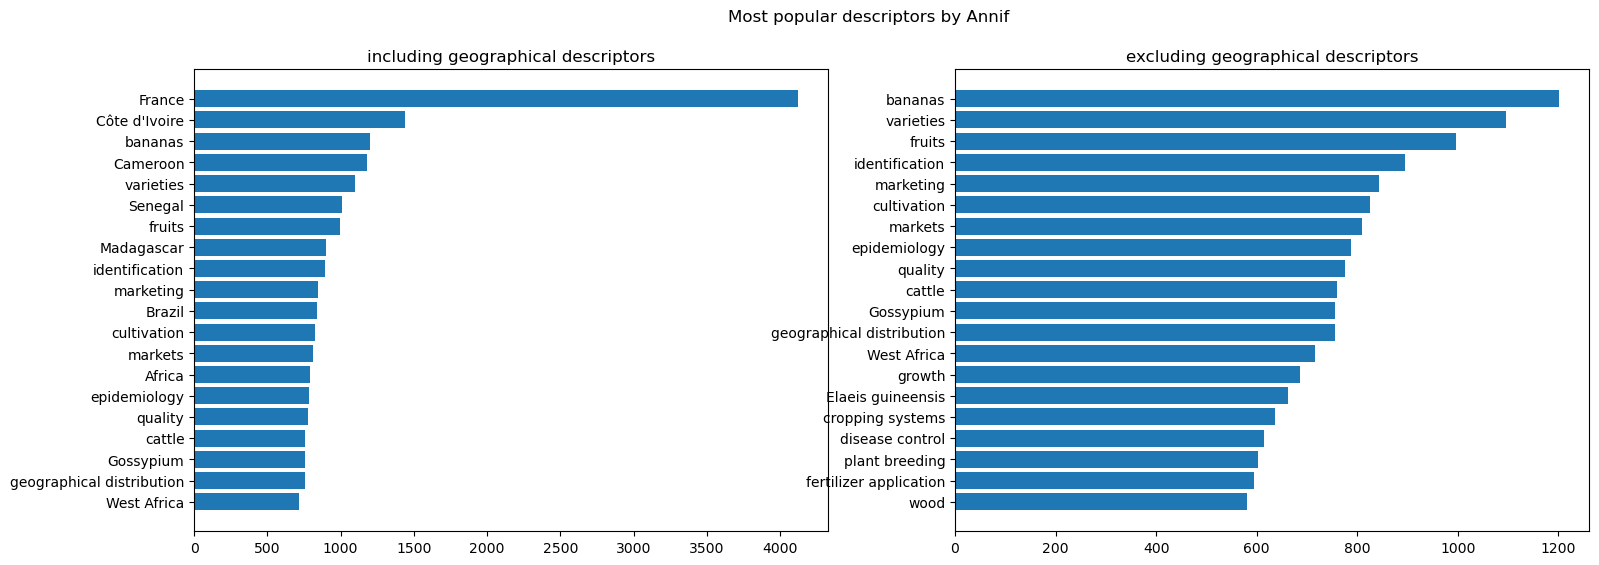

In [97]:
top_20 = df_descr_count['annif'].sort_values(by='cnt', ascending=False)[:20]

df_descr_count_a_top_20_non_geo = df_descr_count['annif'][df_descr_count['annif'].isGeo < 1].sort_values(by='cnt', ascending=False)[:20]

fig = plt.figure(figsize=(18, 6))
fig.suptitle('Most popular descriptors by Annif')

plt.subplot(1,2,1)
plt.barh(top_20.descriptorLabel, width=top_20.cnt) 
plt.gca().invert_yaxis()
plt.title('including geographical descriptors')

plt.subplot(1,2,2)
plt.barh(df_descr_count_a_top_20_non_geo.descriptorLabel, width=df_descr_count_a_top_20_non_geo.cnt) 
plt.gca().invert_yaxis()
plt.title('excluding geographical descriptors')


plt.show()

#### Compare human and automatic indexing

In [98]:
df_merged = df_descr_count['human'].merge(df_descr_count['annif'],
                                            on='uri',
                                            how='outer',
                                            suffixes=['_human', '_annif'] )


df_merged.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cnt_human,"8,005.00",23.24,81.19,1.00,1.00,4.00,13.00,"3,648.00"
isGeo_human,"8,005.00",0.04,0.19,0.00,0.00,0.00,0.00,1.00
cnt_annif,"8,069.00",20.22,82.47,1.00,1.00,2.00,10.00,"4,121.00"
isGeo_annif,"8,069.00",0.04,0.19,0.00,0.00,0.00,0.00,1.00


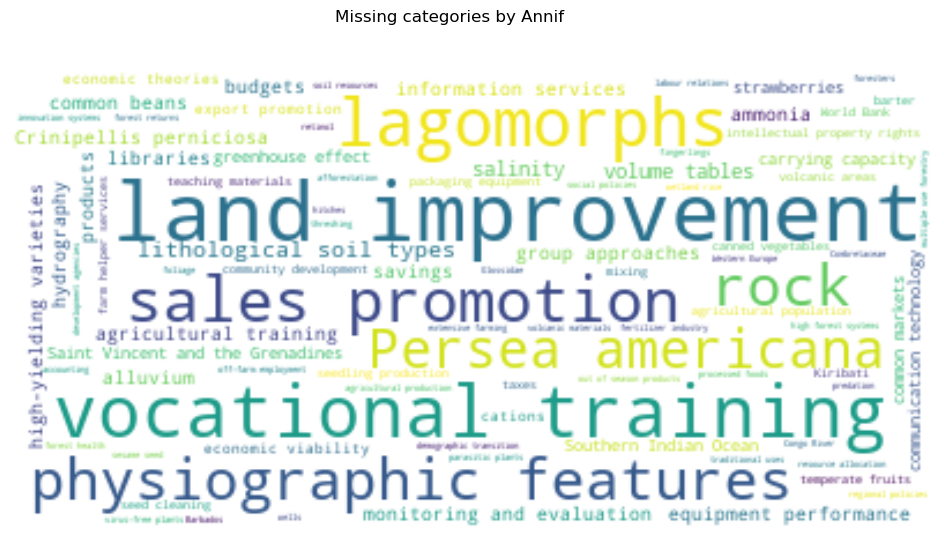

In [99]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

missing_categories = df_merged[df_merged.descriptorLabel_annif.isna()]
missing_categories.shape

freq = dict(zip(missing_categories.descriptorLabel_human, missing_categories.cnt_human)) 
wordcloud = WordCloud(background_color="white").generate_from_frequencies(freq)

# Display the generated image:
fig = plt.figure(figsize=(18, 6))
fig.suptitle('Missing categories by Annif')

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

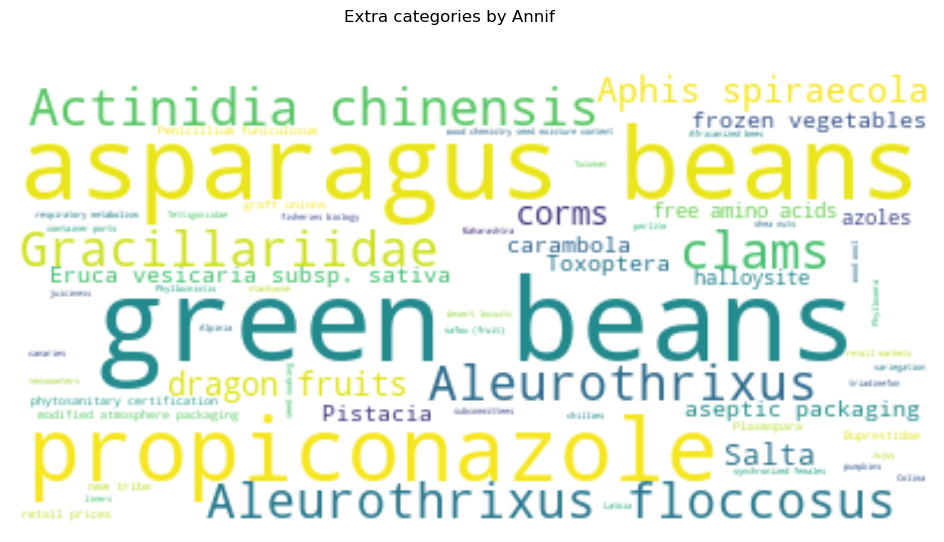

In [100]:
extra_categories = df_merged[df_merged.descriptorLabel_human.isna()]
extra_categories.shape

freq = dict(zip(extra_categories.descriptorLabel_annif, extra_categories.cnt_annif)) 
wordcloud = WordCloud(background_color="white").generate_from_frequencies(freq)


# Display the generated image:
fig = plt.figure(figsize=(18, 6))
fig.suptitle('Extra categories by Annif')

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

CONCLUSION: Annif had missed more general descriptors such as *land improvement* or *vocational training* and added more precise descriptors like *green beens* or *asparagus beans*.  

#### Compare Geographical descriptors

(52, 9)


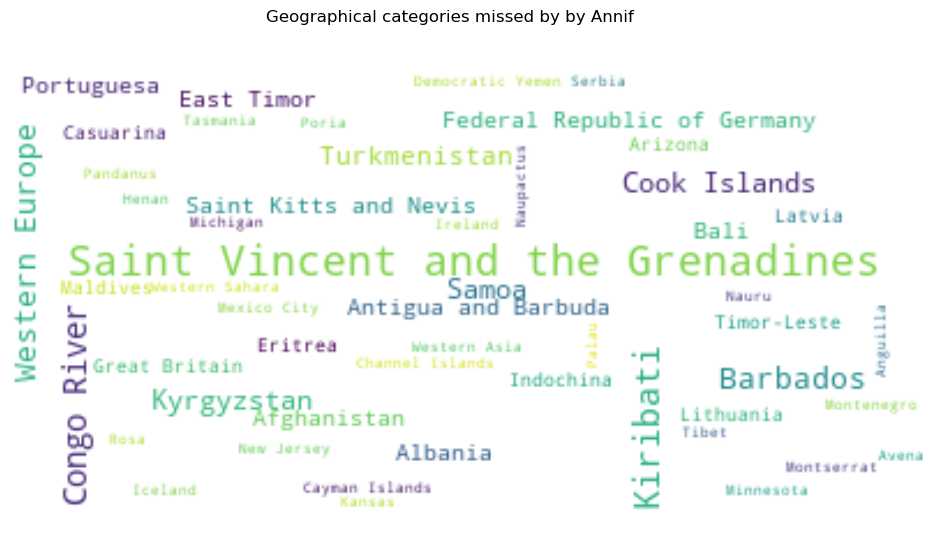

In [101]:
missing_categories_geo = missing_categories[missing_categories.isGeo_human == 1]
print(missing_categories_geo.shape)

freq = dict(zip(missing_categories_geo.descriptorLabel_human, missing_categories_geo.cnt_human)) 
wordcloud = WordCloud(background_color="white").generate_from_frequencies(freq)

# Display the generated image:
fig = plt.figure(figsize=(18, 6))
fig.suptitle('Geographical categories missed by by Annif')

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

(51, 9)


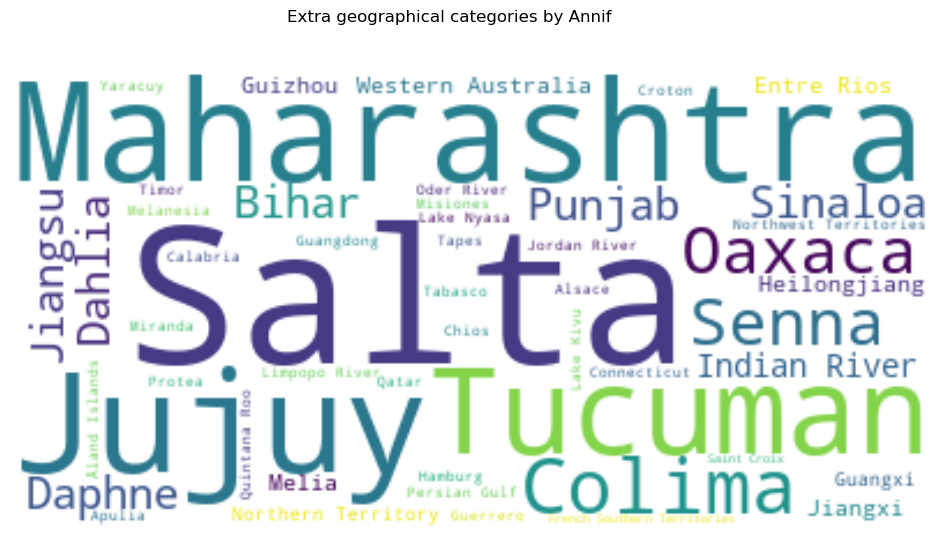

In [102]:
extra_categories_geo = extra_categories[extra_categories.isGeo_annif == 1 ]
print(extra_categories_geo.shape)

freq = dict(zip(extra_categories_geo.descriptorLabel_annif, extra_categories_geo.cnt_annif)) 
wordcloud = WordCloud(background_color="white").generate_from_frequencies(freq)


# Display the generated image:
fig = plt.figure(figsize=(18, 6))
fig.suptitle('Extra geographical categories by Annif')

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

CONCLUSION: It seems that Annif had missed some multi-word geographical locations. Can't say much about the extra geographical categories except that they are not occured more than twice.